In [1]:
# install quandl library
%pip install quandl

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quandl
import json
import os
import stock_time_series as sts
%load_ext autoreload
%autoreload 2

quandl.ApiConfig.api_key = 'z6KvEMELxCcG-Kb72EYY'

In [3]:
# Capture a single stock using quandl API
stocks = ['MSFT']

# Define years of interest to model against
start_year = '1992'
end_year = '1994'
data = quandl.get("WIKI/"+stocks[0])
data

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1986-03-13,25.500,29.250,25.50,28.00,3582600.0,0.0,1.0,0.058941,0.067609,0.058941,0.064720,1.031789e+09
1986-03-14,28.000,29.500,28.00,29.00,1070000.0,0.0,1.0,0.064720,0.068187,0.064720,0.067031,3.081600e+08
1986-03-17,29.000,29.750,29.00,29.50,462400.0,0.0,1.0,0.067031,0.068765,0.067031,0.068187,1.331712e+08
1986-03-18,29.500,29.750,28.50,28.75,235300.0,0.0,1.0,0.068187,0.068765,0.065876,0.066454,6.776640e+07
1986-03-19,28.750,29.000,28.00,28.25,166300.0,0.0,1.0,0.066454,0.067031,0.064720,0.065298,4.789440e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,92.930,94.050,92.21,92.48,23753263.0,0.0,1.0,92.930000,94.050000,92.210000,92.480000,2.375326e+07
2018-03-22,91.265,91.750,89.66,89.79,37578166.0,0.0,1.0,91.265000,91.750000,89.660000,89.790000,3.757817e+07
2018-03-23,89.500,90.460,87.08,87.18,42159397.0,0.0,1.0,89.500000,90.460000,87.080000,87.180000,4.215940e+07


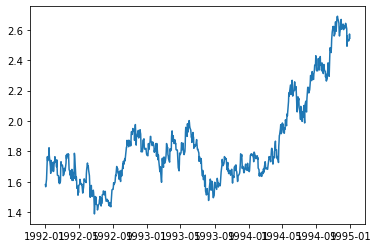

In [4]:
# Plot stock price of individual stock for Adjusted Close price and given years to train against
plt.plot(data['Adj. Close'][start_year:end_year])

# DeepAR Algorithm

We'll be using the DeepAR Algorithm ([DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)) to help us predict future stock values.

I won't get into DeepAR to in detail as the documentation is provided, but DeepAR works best on a large set of similar time series data. We'll convert adjusted close stock prices of the selected stock(s) into individualized prices by year for each stock. To do so, we'll have to convert the dataframe data into a time series of stock prices per year. We'll do that next.

# Convert DataFrame into Time Series

Using Adjusted Close daily data, we need to create a time series where individual adjusted closing prices are separated by year. This will provide individual time series data per year for the DeepAR model to train with.

In [5]:
time_series = sts.make_time_series(data, sts.range_to_years(start_year, end_year))

In [6]:
time_series

[Date
 1992-01-02    1.581017
 1992-01-03    1.567148
 1992-01-06    1.615688
 1992-01-07    1.664228
 1992-01-08    1.723169
                 ...   
 1992-12-24    1.815049
 1992-12-28    1.820249
 1992-12-29    1.799447
 1992-12-30    1.786341
 1992-12-31    1.775939
 Name: Adj. Close, Length: 254, dtype: float64,
 Date
 1993-01-04    1.770739
 1993-01-05    1.799447
 1993-01-06    1.851454
 1993-01-07    1.815049
 1993-01-08    1.812344
                 ...   
 1993-12-27    1.674629
 1993-12-28    1.721436
 1993-12-29    1.695432
 1993-12-30    1.690232
 1993-12-31    1.677126
 Name: Adj. Close, Length: 253, dtype: float64,
 Date
 1994-01-03    1.666724
 1994-01-04    1.674629
 1994-01-05    1.711034
 1994-01-06    1.760337
 1994-01-07    1.773443
                 ...   
 1994-12-23    2.532955
 1994-12-27    2.527546
 1994-12-28    2.537948
 1994-12-29    2.571648
 1994-12-30    2.543357
 Name: Adj. Close, Length: 252, dtype: float64]

In [7]:
# set prediction length
prediction_length = 7    # days

time_series_training = sts.create_training_series(time_series, prediction_length)

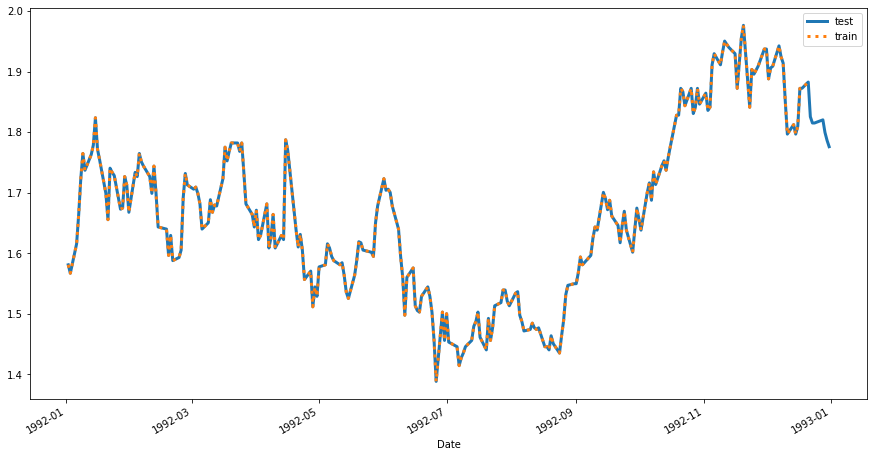

In [8]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

# Convert DataFrame/Series to JSON

DeepAR algorithm requires JSON object input. Need to convert time series data to JSON object.

In [9]:
# test out the code
ts = time_series[0]

json_obj = sts.series_to_json_obj(ts)
print(json_obj)

{'start': '1992-01-02 00:00:00', 'target': [1.5810166450517, 1.5671480779899, 1.6156880627064, 1.6642280474229, 1.7231694574358, 1.7647751586213, 1.7370380244976, 1.7629722449033, 1.7786437256832, 1.8237165686342, 1.7717094421523, 1.7543737333249, 1.6988994650775, 1.6554908501739, 1.7405051662631, 1.7335708827321, 1.7283008272486, 1.6728265590012, 1.6746294727193, 1.7266365992012, 1.7127680321394, 1.6676951891883, 1.7335708827321, 1.7266365992012, 1.7647751586213, 1.7509065915595, 1.7439723080285, 1.7266365992012, 1.6988994650775, 1.7439723080285, 1.6988994650775, 1.6434251968301, 1.6399580550646, 1.596549440161, 1.6295566297682, 1.5879509285826, 1.5930822983955, 1.60528663741, 1.6919651815466, 1.7317679690141, 1.7127680321394, 1.7058337486084, 1.7093008903739, 1.6988994650775, 1.6815637562502, 1.6399580550646, 1.650359480361, 1.6884980397811, 1.6676951891883, 1.6797608425321, 1.6780966144847, 1.7231694574358, 1.7751765839177, 1.7525708196069, 1.7682423003868, 1.7821108674486, 1.782110

In [10]:
# save this data to a local directory
data_dir = 'json_stock_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [11]:
# directories to save train/test data
train_key = os.path.join(data_dir, stocks[0] + '_train.json')
test_key = os.path.join(data_dir, stocks[0] + '_test.json')

# write train/test JSON files
sts.write_json_dataset(time_series_training, train_key)        
sts.write_json_dataset(time_series, test_key)

json_stock_data/MSFT_train.json saved.
json_stock_data/MSFT_test.json saved.


# Uploading to S3
Now we need to upload locally captured data to AWS S3

In [12]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [13]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

Specify paths for training and test data in S3

In [14]:
prefix = 'deepar_' + stocks[0]

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [15]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-2-019506888477/deepar_MSFT/train/MSFT_train.json
Test data is stored in: s3://sagemaker-us-east-2-019506888477/deepar_MSFT/test/MSFT_test.json


# Training DeepAR Estimator

Create/configure a container image for the region I'm using. This container can be passed to a base Estimator that will serve as the estimator for our DeepAR model.

In [16]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [17]:
from sagemaker.estimator import Estimator

# directory to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

## Setting Hyperparameters

We'll define some required hyperparameters to build our model.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

As per recommendation of the DeepAR algorithm documentation, we'll start with context_length = prediction_length. For our algorithm, we'll start with a 7 day prediction window. DeepAR receives lagged inputs from the provided time series (up to one year in some cases), so we don't have to force context_length to be longer than needed. The documentation provides more information on how DeepAR works.

### Optional Hyperparameters

Additionally, we can provide optional hyperparameters (e.g. learning_rate, num_cells, num_layers (to customize the RNN)). These are set by default if not provided. Again, reference the documentation for more information on these hyperparameters.

In [18]:
# need to feed frequency to hyperparameters
# set to 'D' for daily
freq='D'

# assign context_length. Start with it equal to prediction_length
context_length = prediction_length

# best hyperparameters established from tuning job
hyperparameters = {
    "epochs": "29", # started with '25'
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.011354939080335372", # started with '0.001'
    "dropout_rate": "0.19549901048319465", # started with '0.1'
    "early_stopping_patience": "10"
}

In [19]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

### Set up the tuning job

I've established the hyperparameters for the base estimator. Now I'd like to describe the tuning job that I'll need SageMaker to initiate to determine the "optimal" hyperparameters for our time series and model.

Here I'll dictate which hyperparameters I'd like to iterate through, and leave those hyperparameters alone from above that I don't need tuned for this particular job.

In [22]:
# from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

# hyperparameter_tuner = HyperparameterTuner(estimator = estimator, # The estimator object to use as the basis for the training jobs.
#                                                objective_metric_name = 'test:mean_wQuantileLoss', # The metric used to compare trained models.
#                                                objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
#                                                max_jobs = 9, # The total number of models to train
#                                                max_parallel_jobs = 3, # The number of models to train in parallel
#                                                hyperparameter_ranges = {
#                                                     'dropout_rate': ContinuousParameter(0.1, 0.2),
#                                                     'learning_rate': ContinuousParameter(0.0005, 0.05),
#                                                     'epochs': IntegerParameter(1, 50)
#                                                })

### Execute the tuning job

Now that we have our hyperparameter tuner object completely set up, it is time to train it. To do this we make sure that SageMaker knows our input data is in csv format and then execute the `fit` method.

In [23]:
# # tell S3 where the data will be and what type of format to expect
# s3_input_train = sagemaker.s3_input(s3_data=train_path, content_type='json')
# s3_input_test = sagemaker.s3_input(s3_data=test_path, content_type='json')

# # fit
# hyperparameter_tuner.fit({'train': s3_input_train, 'test': s3_input_test})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [24]:
# # visual to know it's fitting still...
# hyperparameter_tuner.wait()

................................................................................................................................................!


In [25]:
# # output configuration of best_training_job. Use SageMaker interface to find actual parameters.
# hyperparameter_tuner.best_training_job()

'forecasting-deepar-200923-0304-008-15bc878e'

## Training Job

Launch our training job with the new best_training_job!

In [20]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

# # establish new estimator from best_training_job (commented out previous estimator)
# estimator_best = sagemaker.estimator.Estimator.attach(hyperparameter_tuner.best_training_job())

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-24 01:48:15 Starting - Starting the training job...
2020-09-24 01:48:17 Starting - Launching requested ML instances......
2020-09-24 01:49:23 Starting - Preparing the instances for training......
2020-09-24 01:50:33 Downloading - Downloading input data...
2020-09-24 01:51:08 Training - Training image download completed. Training in progress.Arguments: train
[09/24/2020 01:51:11 INFO 140651471685440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

## Deploy and Create a Predictor

In [21]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 274 ms, sys: 2.73 ms, total: 277 ms
Wall time: 7min 32s


# Generating Predictions

According to the DeepAR documentation, the DeepAR predictor expects to see inputa data in JSON format. We need to convert our time series into a JSON instance in order to obtain predicted prices.

In [22]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = sts.json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

## Decoding Predictions

The predictor also returns a JSON formatted perdiction. Thus, we need to pull out the predictions from the JSON instance.

We have written a function in stock_time_series.py that takes in the predictor output and returns a list of predictions in each quantile of interest (0.1, 0.5, 0.9).

In [23]:
# get quantiles/predictions
prediction_list = sts.decode_prediction(json_prediction)

# should get a list of predictions (of length prediction_length)
# with corresponding quantile values
print(prediction_list[0])

        0.1       0.9       0.5
0  1.773268  1.976572  1.873417
1  1.795396  1.956256  1.877727
2  1.799155  1.956705  1.881243
3  1.792670  2.009346  1.891957
4  1.800344  1.946372  1.885009
5  1.793254  1.940436  1.878083
6  1.797405  1.952623  1.878088


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.


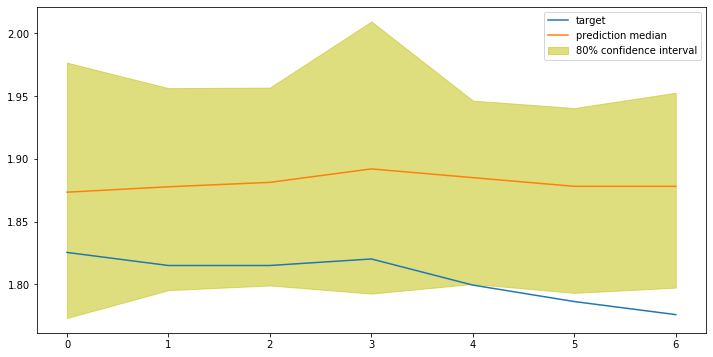

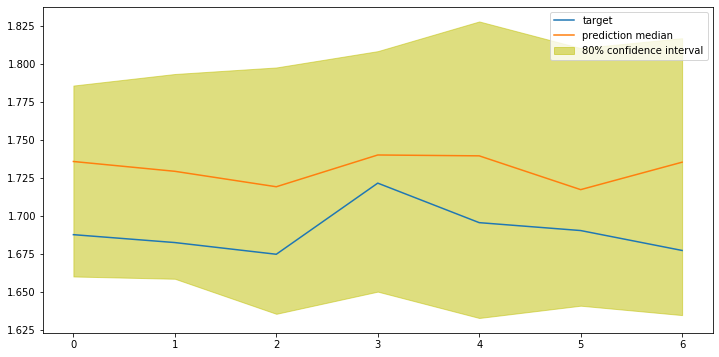

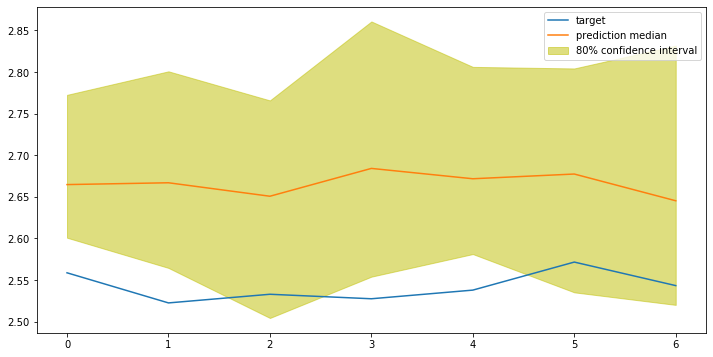

In [24]:
# display predictions (0.1, 0.9, 0.5)
sts.display_quantiles(prediction_list, prediction_length, target_ts)

## Test Prediction of "Future" Data

Now let's test our model on data it hasn't actually seen -- thus, no target to compare against.

In [25]:
# Starting my prediction on first trading day of 1995
start_date = '1995-01-03'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

# formatting request_data
# this instance has an empty target!
request_data = {"instances": [{"start": start_time, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 1995-01-03 00:00:00


Then get and decode the prediction response, as usual.

In [26]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_future = sts.decode_prediction(json_prediction)

print(prediction_future)

[        0.1       0.9       0.5
0  1.667725  1.846145  1.755588
1  1.731586  1.863697  1.799149
2  1.797096  1.922891  1.862165
3  1.821709  1.999512  1.902655
4  1.833524  1.951883  1.901045
5  1.860099  1.980434  1.929240
6  1.891173  2.010568  1.953242]


We need to compare these predictions to the actual values from the "future".

In [27]:
# create "future" time series
ts_future = []

# get "future" data
data_future = data[start_date[:-6]]['Adj. Close']

ts_future.append(pd.Series(data=data_future.values, index=data_future.index))
ts_future

[Date
 1995-01-03    2.504247
 1995-01-04    2.522554
 1995-01-05    2.480948
 1995-01-06    2.522554
 1995-01-09    2.506743
                 ...   
 1995-12-22    3.765316
 1995-12-26    3.754915
 1995-12-27    3.697499
 1995-12-28    3.635090
 1995-12-29    3.650900
 Length: 252, dtype: float64]

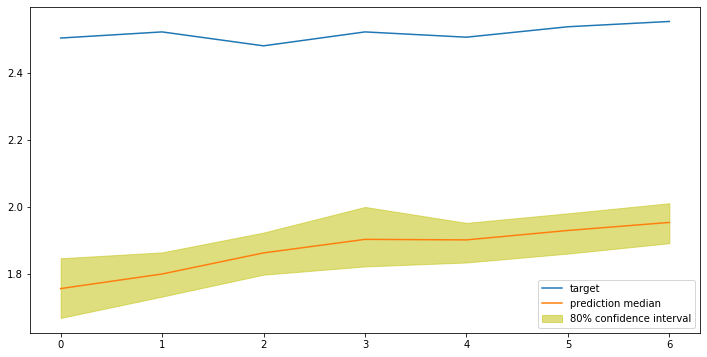

In [28]:
# range of actual data to compare
start_idx=0 # days since Jan 4th 1995
end_idx=start_idx+prediction_length

# get target data
target_future_ts = [ts_future[0][start_idx:end_idx]]

# display predictions
sts.display_quantiles(prediction_future, prediction_length, target_future_ts)

# Naive Model
The Naive model can be used as a benchmark to determine how well our model compares at forecasting a predicted value to a near random walk. The Naive model states that the predicted value will be equal to the most recent observable past data point.

$Ŷ(t+h|t) = Y(t)$

In [29]:
target = pd.DataFrame(target_future_ts[0]).reset_index()
target = target.drop(columns='Date')
target

,0
0,2.504247
1,2.522554
2,2.480948
3,2.522554
4,2.506743
5,2.537948
6,2.553758


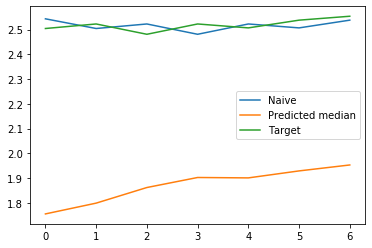

In [30]:
naive_data = data['1994-12-30':'1995-01-10']['Adj. Close']
naive_data = naive_data.reset_index()
naive_data = naive_data.drop(columns='Date')
naive_data
plt.plot(naive_data, label='Naive')
plt.plot(prediction_future[0]['0.5'], label='Predicted median')
plt.plot(target, label='Target')
plt.legend()

# Accuracy

We'll define the accuracy of our model using a percentage difference calculation, or mean average percentage error (MAPE). MAPE provides us with a unitary stastical measure for the accuracy of an entire time series over a given period. We'll calculate per the provided formula.

${\mbox{M}}={\frac  {1}{n}}\sum _{{t=1}}^{n}\left|{\frac  {A_{t}-F_{t}}{A_{t}}}\right|$

where $n$ is the number of fitted periods, $A_t$ is the actual value and $F_t$ is the forecast value.

In [31]:
def mape(benchmark, target_future_ts):
    mape_ts = [100 * abs(benchmark[i] - target_future_ts[0][i])/target_future_ts[0][i] for i in range(len(target_future_ts[0]))]
    return sum(mape_ts)/prediction_length

# Calculate MAPE (in PERCENTAGE) for our DeepAR model
mape(prediction_future[0]['0.5'], target_future_ts)

25.678666796535655

In [32]:
naive_data = pd.Series(naive_data['Adj. Close'].values)

In [33]:
# Calculate MAPE for Naive
mape(naive_data, target_future_ts)

1.1561570060642568

## Delete the Endpoint

In [34]:
## TODO: delete the endpoint
predictor.delete_endpoint()